<img  src="https://www.bcm.edu/themes/custom/bcm_bootstrap_subtheme/css/../images/BCM-90x90.svg" alt="Drawing" style="height: 100px;float: left;"/>

# Real-time $R_t$ of COVID-19 pandemic in TMC (Until 9/1/2020)

In [1]:
param_days = 10
param_std = 2.3
param_sigma = 0.10

In [2]:
%expand --in Python3
This report estimates the county level real-time effective production number ($R_t$) of the COVID-19 pandemic in Texas Medical Center. It is report is created and maintained by data scientists
from the [Institute for Clinical & Translational Research, Baylor College of Medicine](https://www.bcm.edu/research/research-offices/institute-for-clinical-translational-research), with an algorithm that is based
on [Kevin Systrom's work](https://github.com/k-sys/covid-19) for the US data. Please refer to the original report for details.

This report uses `{param_days}` day rolling average of daily new case data and smoothing parameters `std={param_std}` and `sigma={param_sigma}`.

This report estimates the county level real-time effective production number ($R_t$) of the COVID-19 pandemic in Texas Medical Center. It is report is created and maintained by data scientists
from the [Institute for Clinical & Translational Research, Baylor College of Medicine](https://www.bcm.edu/research/research-offices/institute-for-clinical-translational-research), with an algorithm that is based
on [Kevin Systrom's work](https://github.com/k-sys/covid-19) for the US data. Please refer to the original report for details.

This report uses `10` day rolling average of daily new case data and smoothing parameters `std=2.3` and `sigma=0.1`.


In [3]:
import pandas as pd
tmc_data = pd.read_excel('TMC/Total Tests by Date and Source - 09012020.xlsx')
tmc_data = tmc_data.dropna()
tmc_data = tmc_data[tmc_data["Collected Date"] != "Grand Total"]
tmc_data['Collected Date']= pd.to_datetime(tmc_data['Collected Date']) 
tmc_data = tmc_data.sort_values(by='Collected Date').set_index('Collected Date')
tmc_cases = tmc_data['POSITIVE Per Day'].cumsum()

In [4]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGION_CODES = [] #'AS', 'GU', 'PR', 'VI', 'MP']

%config InlineBackend.figure_format = 'retina'

In [5]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
#print(y.shape)

In [6]:
k = 20

lam = np.linspace(1, 45, 90)

In [7]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

In [8]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

In [9]:
most_likely_values = posteriors.idxmax(axis=0)

In [10]:
def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors, debug=True)

## Daily New Cases

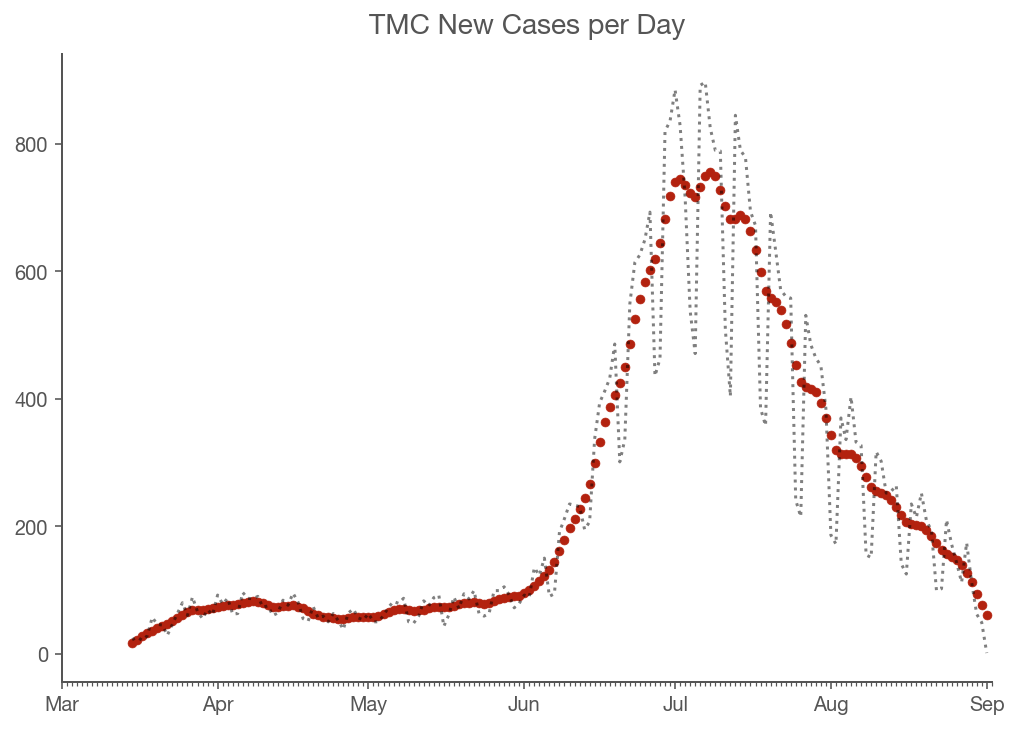

In [11]:
def prepare_cases(cases, cutoff=15, smooth_days=7, smooth_std=2):
    new_cases = cases.diff()
    
    smoothed = new_cases.rolling(smooth_days,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=smooth_std).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

def plot_cases(cases, ax, cutoff=15, smooth_days=7, smooth_std=2):
    original, smoothed = prepare_cases(cases, cutoff=cutoff, smooth_days=smooth_days,
                                           smooth_std=smooth_std)
    
    index = original.index.get_level_values('Collected Date')
    values = original.values
    ax.plot(index, values, 
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual')
    ax.set_title(f"TMC New Cases per Day")
    index = smoothed.index.get_level_values('Collected Date')
    values = smoothed.values
    ax.scatter(index, values, label='Smoothed', lw=0.3, s=20)
    ax.get_figure().set_facecolor('w')
    #ax.set_xticklabels(, rotation=45, ha='right')
    
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())    
    ax.set_xlim(pd.Timestamp('2020-03-01'), original.index.get_level_values('Collected Date')[-1]+pd.Timedelta(days=1))
    
#county_name = 'Brewster'

original, smoothed = prepare_cases(tmc_cases, smooth_days=param_days, smooth_std=param_std)
fig, ax = plt.subplots(figsize=(600/72,400/72))
plot_cases(tmc_cases, ax, smooth_days=param_days, smooth_std=param_std)

In [12]:
def get_posteriors(sr, sigma):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=param_sigma)

In [13]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

## Estimated real-time production number

In [14]:
result.tail(n=15)

,ML,Low_90,High_90
Collected Date,,,
2020-08-18,0.79,0.42,1.11
2020-08-19,0.81,0.43,1.13
2020-08-20,0.81,0.43,1.13
2020-08-21,0.78,0.42,1.12
2020-08-22,0.74,0.36,1.07
2020-08-23,0.71,0.32,1.04
2020-08-24,0.71,0.32,1.05
2020-08-25,0.73,0.33,1.07
2020-08-26,0.73,0.32,1.07


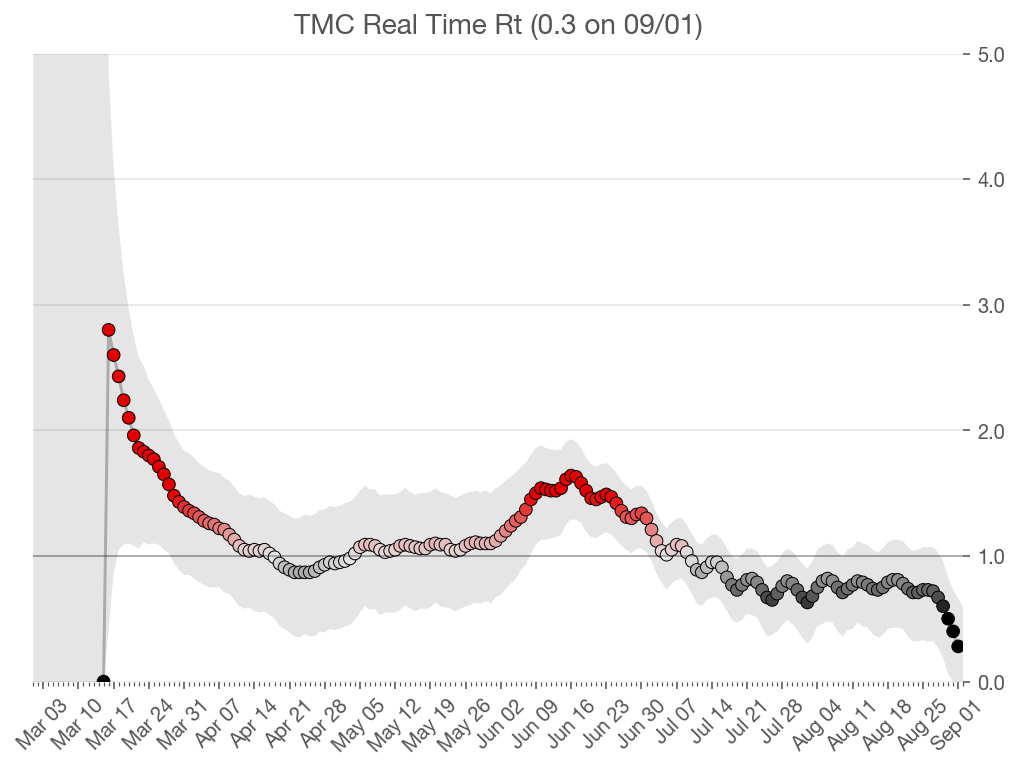

In [15]:
def plot_rt(result, ax):
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('Collected Date')
    values = result['ML'].values
    ax.set_title(f'TMC Real Time Rt ({values[-1]:.1f} on {result.index.get_level_values("Collected Date")[-1].strftime("%m/%d")})')
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), 
                result.index.get_level_values('Collected Date')[-1] + pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax)
#ax.set_title(f'Real-time $R_t$ for {county_name} (till {result.index.get_level_values("date")[-1].strftime("%m/%d")})')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45);
